# Build a regression model on the Ames housing dataset using fastai
Kaggle leaderboard is [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard)  
From Kaggle:  
"Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)"

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
ames_data = pd.read_csv("AmesHousing.csv")

In [3]:
ames_data.head()

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       5    2010       WD           Normal     215000  
1        0       6    2010       WD           Normal     105000  
2    12500       6    2010       WD           Normal     172000  
3        0       4    2010       WD           Normal     244000  
4        0       3    2010       WD           Normal     189900  

[5 rows x 82 columns]

In [4]:
# sp_std = ames_data['SalePrice'].std()
# sp_mean = ames_data['SalePrice'].mean()
# sp = ames_data['SalePrice']

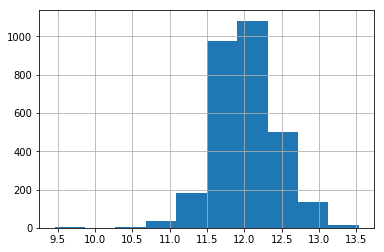

In [5]:
# log the sale price
ames_data['LogSalePrice'] = np.log(ames_data['SalePrice'])
ames_data['LogSalePrice'].hist()

In [6]:
# # normalize the sale price
# ames_data['NormSalePrice'] = (sp - sp_mean) / sp_std
# ames_data['NormSalePrice'].hist()

In [7]:
sp = ames_data['SalePrice']
ames_data['SalePrice'] = None

Remove variables where missingness is extreme (say > 25%)

In [8]:
def percent_null(pd_column):
    return sum(pd_column.isnull())/len(pd_column)

In [9]:
ames_perc_null = [percent_null(ames_data[col]) for col in ames_data.columns]
filtered_ames_data = ames_data.iloc[:,[e < .25 for e in ames_perc_null]]
ames_perc_null = [percent_null(filtered_ames_data[col]) for col in filtered_ames_data.columns]

Quick sanity check

In [10]:
any([r > .25 for r in ames_perc_null])

False

Dummy-encoding and imputation is handled by fastai

## Now build a model

In [11]:
from fastai.tabular import *

In [14]:
def is_categorical(feature_vector, threshold=30):
    """
    Takes a feature vector and an integer threshold value.
    If the number of unique values in the vector is fewer than the threhold,
    the function returns true (e.g. this is a categorical feature)
    """
    if len(set(feature_vector)) < threshold:
        return True
    else:
        return False

In [15]:
filtered_ames_data.shape

(2930, 77)

In [17]:
dep_var = 'LogSalePrice'
cat_names = [c for c in filtered_ames_data.columns if is_categorical( filtered_ames_data[c], 30 ) ]

In [18]:
cont_names = [name for name in filtered_ames_data.columns if (name not in cat_names and name not in dep_var)]

In [19]:
procs = [FillMissing, Categorify, Normalize]

In [20]:
filtered_ames_data.shape

(2930, 77)

In [21]:
test_set_range = [2500, 2930]

In [52]:
test = TabularList.from_df(filtered_ames_data.iloc[test_set_range[0]:test_set_range[1]].copy(),
                           path=Path("."),
                           cat_names=cat_names,
                           cont_names=cont_names)

In [53]:
data = (TabularList.from_df(filtered_ames_data,
                            path=Path("."),
                            cat_names=cat_names,
                            cont_names=cont_names,
                            procs=procs)
                           .split_by_idx(list(range(800,1000)))
                           .label_from_df(cols=dep_var, label_cls=FloatList)
                           .add_test(test)
                           .databunch())

In [54]:
data.show_batch(rows=3)

In [96]:
learn = tabular_learner(data, layers=[150,150,150,150], metrics=root_mean_squared_error) # 6 epochs
# learn = tabular_learner(data, layers=[500,300,200,100], metrics=root_mean_squared_error)
# learn = tabular_learner(data, layers=[100,100], metrics=root_mean_squared_error)

In [97]:
learn.fit(6)

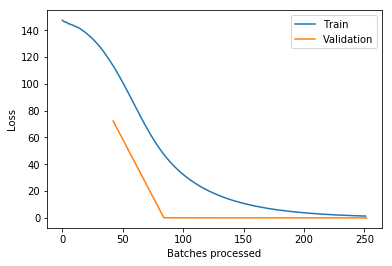

In [98]:
learn.recorder.plot_losses()

Cheated a little to get .116 (it's very variable)!!  
That wouild (however) be 673/4695

In [99]:
673/4695

0.1433439829605964

In [ ]:
# cont_names = ["Lot Frontage", "Lot Area", "Overall Qual", "Overall Cond", "Year Built", "Year Remod/Add", "Mas Vnr Area",\
#               "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF",\
#               "Gr Liv Area", "Bsmt Full Bath", "Bsmt Half Bath", "Full Bath", "Half Bath", "Bedroom AbvGr", "Kitchen AbvGr",\
#               "TotRms AbvGrd", "Fireplaces", "Garage Yr Blt", "Garage Finish", "Garage Cars", "Garage Area", "Wood Deck SF",\
#               "Open Porch SF", "Enclosed Porch", "3Ssn Porch", "Screen Porch", "Pool Area", "Misc Val", "Mo Sold", "Yr Sold", "SalePrice"]